## DBSCAN ##
DBSCAN stands for density-based spatial clustering of applications with noise. It is efficient to find arbitrary shaped clusters and clusters with noise (i.e. outliers).
The main concept in this algorithm is, a point will belong to a cluster if it close to many points from that cluster, which means the point is in a dense region.


Certain literature from Ester et.al might be helpful to understand the algorithm and the parameters.

Epsilon neighborhood of a point: The Eps neighborhood of a point p, in a dataset D, denoted by $N_{Eps}(p)$, is defined as

$$N_{Eps}(p) = \{q \in D \mid dist(p,q) \leq \epsilon\}$$

where $\epsilon$ is the radius of the neighborhood around the point.

Density at a point p: Number of points within a circle of radius $\epsilon$ from point p. 

Dense Region: For each point in the cluster, the circle with radius $\epsilon$ contains at least minimum number of points. In the algorithm we can specify this minimum number of points as a parameter min_samples. In some literature this is mentioned as MinPts.

Core point: A point is a core point if there are at least “minimum number of points” in its surrounding area with radius $\epsilon$.

Border point: A point is a border point if it is reachable from a core point and there are less than “minimum number of points” within its surrounding area.

Outlier: A point is an outlier if it is neither a core point nor a border point.

Direct density reachable: A point p is directly density reachable from another point q if q is a core point and p is in the $\epsilon$ neighborhood of q.

Density reachable: A point p is density reachable from a point q wrt. $\epsilon$ and Minimum number of points 

if there is a chain of points $p_l$, $p_2$, ... $p_n$, $p_l$ = $q$, $p_n$ = $p$ 
such that $p_{i+1}$ is directly density-reachable from $p_i$.
Density-reachability is a canonical extension of direct density-reachability.

Density connected: A point p is density reachable from a point q wrt. $\epsilon$ and Minimum number of points 
if there is a point o such that both p and q are Density reachable from o.


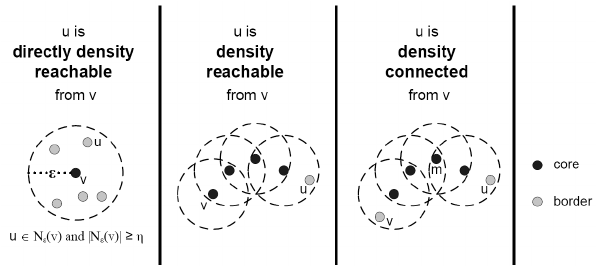


A density-based cluster is defined as a group of density connected points. 

### The steps of the algorithm is as below. ###

1. For each point $x_{i}$, determine how many points are present in the $\epsilon$ neighborhood.
2. If this count is greater or equal to the minimum number of points, then mark the point as a core point.
3. Cluster formation starts.  Find recursively all its density connected points and assign them to the same cluster as the core point.
4. Iterate through the remaining unvisited points in the dataset.
5. Every core point will be assigned to a new cluster unless some of the core points share neighbourhood points, they will be included in the same cluster.
6. Those points that do not belong to any cluster are treated as outliers or noise.


### In scikit learn there are two key parameters of DBSCAN ###

**eps** : The maximum distance between two samples for one to be considered as in the neighborhood of the other. With a smaller value more points will be considered as outlier.

**min_samples** : The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.  With a higher value, more points will be considered as outlier.

### Output from the algorithm ###
**clusterer.labels_** : All the different cluster labels created by the algorithm are provided as output. The outliers can be found by the label of -1. 

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
import seaborn as sns
import sklearn.datasets as data

import hdbscan

In [20]:
#dir(DBSCAN)

In [2]:
#Determine centroids
centers = [[0.5, 2], [-1, -1], [1.5, -1]]
#Create dataset
X, y = make_blobs(n_samples=500, centers=centers, 
                  cluster_std=0.5, random_state=0)
#Normalize the values
X = StandardScaler().fit_transform(X)

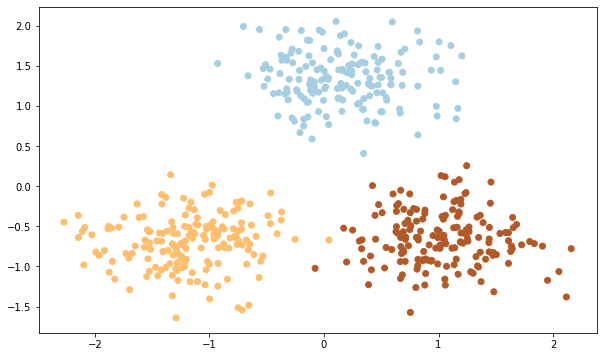

In [3]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='Paired')

In [4]:
#Execute DBSCAN
dbscan_cluster = DBSCAN(eps=0.4, min_samples=30)
dbscan_cluster.fit(X)

DBSCAN(eps=0.4, min_samples=30)

Text(0.5, 1.0, 'Clusters created by DBSCAN')

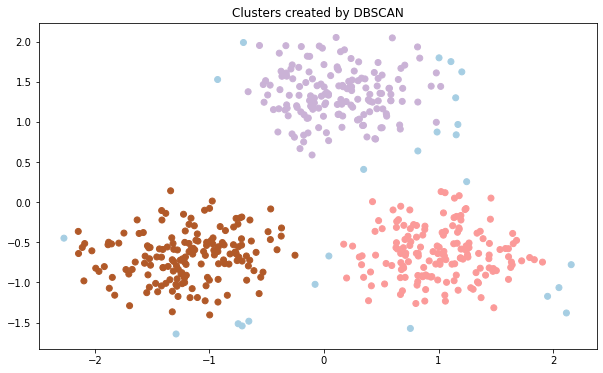

In [5]:
y_pred = dbscan_cluster.fit_predict(X)
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
plt.title("Clusters created by DBSCAN")

### plot interpretation ###
1. Blobs - with very small eps = .1, the clustering is not working correctly. most of the points are considered as outliers.  if we increase the value, it will improve.
2. For circle, with very small eps, the result is good.  because only with small eps, the 2 points in the 2 different circles can be sperated with the density connectivity logic.  if eps is high these 2 points will be densly connected and will be in the same cluster.
3. For moon, there is a lot of separation hence it can separte well with upto .3 eps value but not after that.
4. eps = .14 is better to use.

4. for HDBSCAN, min_cluster_size = 10 is giving better result.

## HDBSCAN ##
HDBSCAN (Hierarchical Density-Based Spatial Clustering and Application with Noise) is an unsupervised clustering algorithm which expands the DBSCAN algorithm and integrates the hierarchical approach. 
As we know the DBSCAN algorithm requires the input parameters as epsilon and min_samples which requires pre domain knowledge about data.  DBSCAN algorithm is not so efficient where there are different densities present in the data.  
In HDBSCAN, the algorithm works for varying epsilon hence it can also be referred as non-parametric algorithm.  This makes the algorithm very efficient even with different densities in the data.

### Below are the steps performed by the algorithm. ###
1.	Transform the space according to the density/sparsity.

The foundation of the algorithm is based on single linkage clustering, which is a bottom-up approach of agglomerative clustering where at the bottom all individual data points are considered as individual clusters and based on the similarity between the data points, the clusters are combined and in the end there is only one single cluster.
To make the model robust to the outliers, in this very first step a new distance metric, mutual reachability distance is created which can be defined as 

$$d_{mreach}(a,b) = max\{core_k(a), core_k(b), d(a,b)\}$$

where $core_k(a)$ and $core_k(b)$ are the core distances defined for parameter $k$ for the points $a$ and $b$.

$k$ is the required minimum number of points.

$d(a,b)$ is the original metric distance between $a$ and $b$.

$d_{mreach}(a,b)$ is the mutual reachability distance.

2.	Build the minimum spanning tree of the distance weighted graph.

Conceptually in this step, the data is considered as a weighted graph with the data points as vertices and an edge between any two points with weight equal to the mutual reachability distance of those points.

3.	Construct a cluster hierarchy of connected components.

The next step is to create a hierarchy of connected components. The concept is, 2 points will be connected based on the edge which represents the mutual reachability between 2 points.  

4.	Condense the cluster hierarchy based on minimum cluster size.

In this step, a smaller condensed tree is created. Using the input parameter, minimum cluster size, at each split the condition is checked whether one of the new clusters created by the split has fewer points than the minimum cluster size or not. If it has fewer points, then it will not be considered as cluster instead, it will be considered as ‘points falling out of a cluster’.  Otherwise it will be considered as a persistent cluster. 

5.	Extract the stable clusters from the condensed tree.

In the last step the clusters are selected based on the eom, excess of mass.  This method, which refers back to the research by Hartigan, is recommended by Campello et al. as the optimal global solution to the problem of finding clusters with the highest
stability. HDBSCAN’s selection algorithm traverses the condensed cluster tree bottom-up and selects the cluster with highest stability on each path. If a cluster is selected then any cluster that is a descendant of it, can not be a cluster.


### The key parameters for the algorithm are as below. ###

**min_cluster_size** is the smallest size grouping that we wish to consider a cluster.  If we increase the value, then smaller number of clusters will be created.  The deafult is 5.

However, there is another parameter which has significant effect in this intuition.

**min_samples** is yet another very important parameter which can be used to control the conservativeness of clustering.  The larger the value of min_samples you provide, the more conservative the clustering – more points will be declared as noise, and clusters will be restricted to progressively more dense areas.

If not specified the default value for this paramater will be same as min_cluster_size.

**cluster_selection_epsilon**  ensures that clusters below the given threshold are not split up any further.

**alpha** is part of the RobustSingleLinkage code, but flows naturally into HDBSCAN.  The default value is 1.0.  It’s better not to change this parameter as adjusting alpha will result in recomputing the hard computation of the single linkage tree.


### Output from the algorithm ###
**clusterer.labels_** : All the different cluster labels created by the algorithm are provided as output. The outliers can be found by the label of -1. 

**clusterer.probabilities_** : For each cluster we have the $\lambda_p$ for each point $p$ in that cluster; which measures the strength of cluster membership for each point.

**outlier_scores_** : This output is a vector of score values, one for each data point that was fit. Higher scores represent more outlier like objects. Selecting outliers via upper quantiles is often a good approach.


### Soft clustering for HDBSCAN ###
To implement soft clustering we need to produce a method of providing a soft membership vector for a given point across the selected clusters of a clustering. Ideally we want this to be interpretable as a probability of being a member of that cluster. 






In [6]:
# execute hdbscan
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, prediction_data=True)
hdbscan_cluster.fit(X)

HDBSCAN(gen_min_span_tree=True, prediction_data=True)

In [18]:
#print(hdbscan_cluster.outlier_scores_)

Text(0.5, 1.0, 'Clusters created by HDBSCAN')

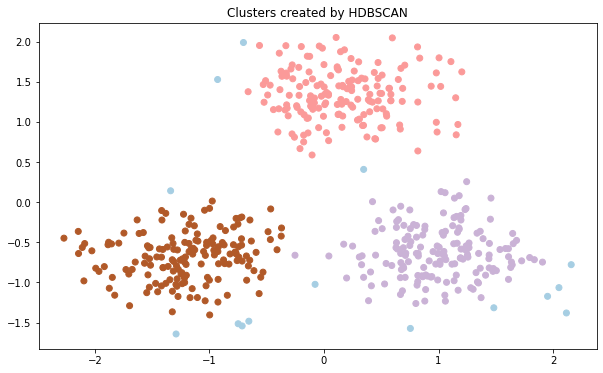

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1],c=hdbscan_cluster.labels_, cmap='Paired')
plt.title("Clusters created by HDBSCAN")

In [8]:
# sample code from https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

plt.figure(figsize=(20,10))
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

<Figure size 1440x720 with 0 Axes>

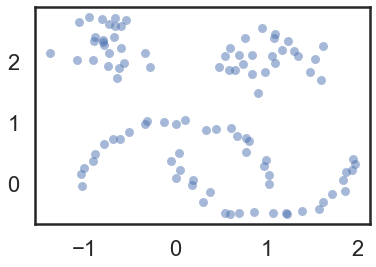

In [10]:
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data = np.vstack([moons, blobs])
plt.scatter(test_data.T[0], test_data.T[1], color='b', **plot_kwds)

In [11]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True, prediction_data=True)
clusterer.fit(test_data)

HDBSCAN(gen_min_span_tree=True, prediction_data=True)

<AxesSubplot:>

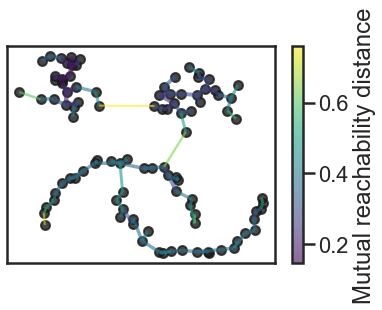

In [12]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

<AxesSubplot:ylabel='distance'>

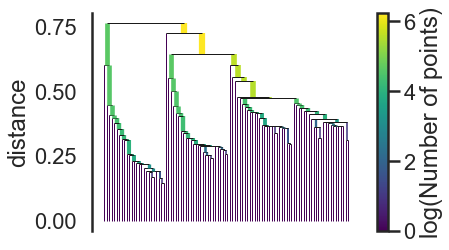

In [13]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

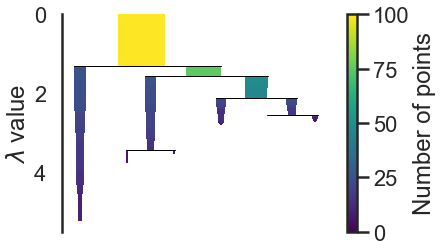

In [14]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

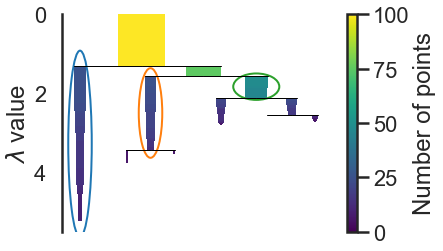

In [15]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

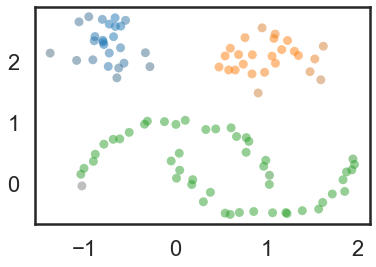

In [16]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(test_data.T[0], test_data.T[1], c=cluster_colors, **plot_kwds)